# Deep Learning: Image Captioning

In [1]:
#!pip install multiprocess
#!pip install torchsummary
#!pip install nltk
#!pip install torchtext
#!pip install spacy

In [2]:
import sys
sys.path.append('..')
import os
import time
import subprocess
import shutil
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle
import nltk

import program.data
from program.dataset import CustomDataset
from program.train import train_network, collate_fn

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchtext.data.metrics import bleu_score
from torchvision.io import read_image

In [3]:
sns.set_palette('Paired')
sns.set_style('whitegrid')

In [4]:
# Downloads data from drive / Flickr8k data needs to be unpacked after download separately
# Wait some time until downloaded! Needs to be runned first especially the download of flickr8k.zip
download_custom_data = True

if download_custom_data:
    subprocess.call(['python', 'download_data.py'], cwd='./data')

******************** Starting Downloads ********************
Folder already exist ./custom_images
File already exist: test_captions.csv, train_captions.csv
******************** Finished Downloads ********************


# Data

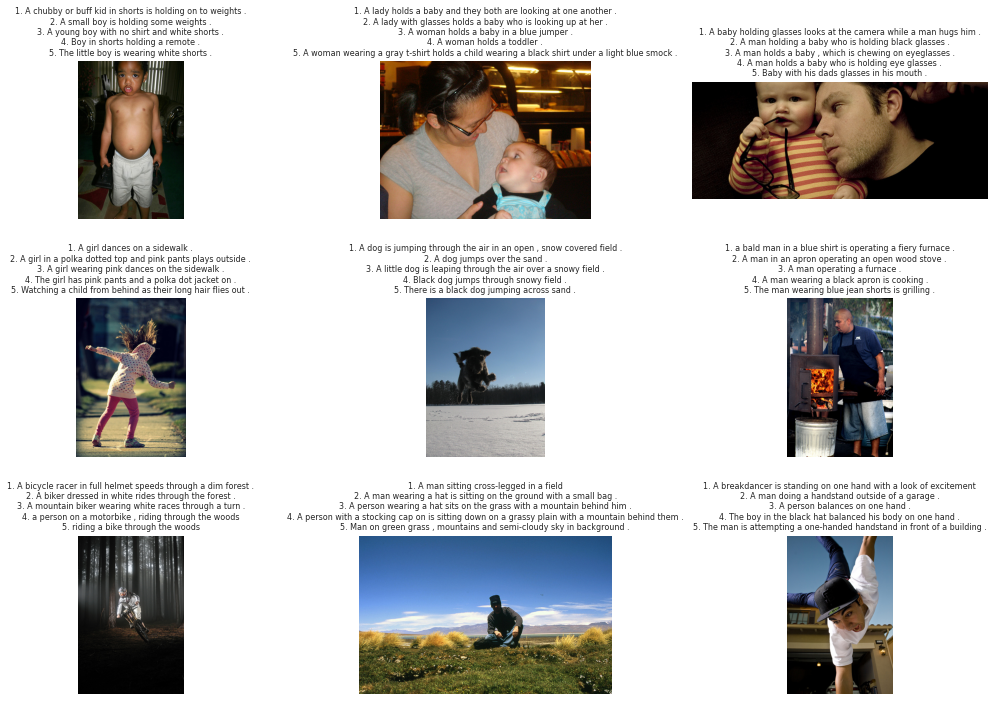

In [5]:
program.data.show_random_images(image_dir='./data/Images', captions_path='./data/train_captions.csv', count=9)

**Beschreibung:**

Das Bild zeigt einige Beispielbilder mit den dazugehörigen Captions. Pro Bild gibt es grundsätzlich 5 verschiedene Captions.

In [6]:
image_captions = pd.read_table('./data/train_captions.csv', sep=',')
image_captions.head(2)

,image,caption
0,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


Der Datensatz mit den Captions kann als CSV eingelesen werden. Pro Bild exisiteren mehrere Captions.

## Generate Train-Validate-Test

In [7]:
def generate_image_splits(image_folder, test_size=1000):
    images = np.array(os.listdir('./data/Images/'))
    np.random.shuffle(images)
    train_size = images.shape[0] - test_size
    train_images = images[:train_size]
    assert len(train_images) == train_size
    images = images[train_size:]

    test_images = images
    assert len(test_images) == test_size
    
    return (train_images, test_images)

In [8]:
generate_splits = False

if generate_splits:
    train_images, test_images = generate_image_splits(image_folder='./data/train/', 
                                                                     test_size=1000, validation_size=1000)

    # prepare files to copy with multiprocessing
    train_images = ['./data/Images/'+img for img in train_images]
    train_images = [img + '__' + './data/train/' + img.split('/')[-1] for img in train_images]

    test_images = ['./data/Images/'+img for img in test_images]
    test_images = [img + '__' + './data/test/' + img.split('/')[-1] for img in test_images]

In [9]:
# Check if works
function_check = False
if function_check:
    amount_test_images = 100
    test_img = train_images[:amount_test_images]
    program.data.copy_all_files(fp_from_to=test_img)

    for img in tqdm(test_img, desc='Deleting Images again'):
        assert os.path.isfile(img.split('__')[-1])
        os.remove(img.split('__')[-1])

In [10]:
copy_files = False
if copy_files:
    program.data.copy_all_files(fp_from_to=train_images)
    program.data.copy_all_files(fp_from_to=validation_images)
    program.data.copy_all_files(fp_from_to=test_images)

In [11]:
save_caps_per_split = False

if save_caps_per_split:
    train_caps = image_captions[image_captions['image'].isin(os.listdir('./data/train/'))]
    assert 5*len(os.listdir('./data/train/')) == train_caps.shape[0]
    train_caps.to_csv('./data/train_captions.csv', index=False)

    test_caps = image_captions[image_captions['image'].isin(os.listdir('./data/test/'))]
    assert 5*len(os.listdir('./data/test/')) == test_caps.shape[0]
    test_caps.to_csv('./data/test_captions.csv', index=False)

## Preprocess Text-Data

In [12]:
from program.captions import TextPreprocessor, TextHandler

In [13]:
processor = TextPreprocessor(n_processes=8, max_sequence_length=10, start_token='<START>', end_token='<END>', pad_fill=True)

In [14]:
processor.tokenize(X = image_captions['caption'].to_list())

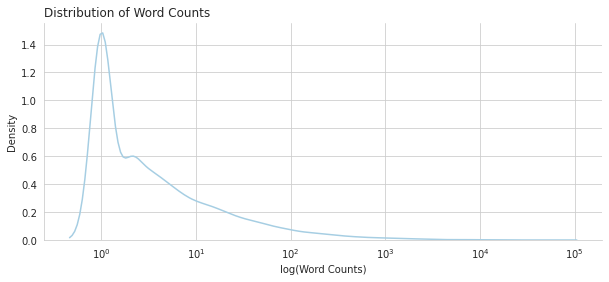

In [15]:
word_counts = processor.count_words()
word_counts = pd.Series(word_counts).sort_values(ascending=False)
word_counts = word_counts.drop([processor.end_token, processor.start_token, processor.fill_token])
#word_counts = np.log(word_counts)

fig = plt.subplots(figsize=(10, 4))
p = sns.kdeplot(word_counts, log_scale=True)
p.set_title('Distribution of Word Counts', loc='left')
p.set_xlabel('log(Word Counts)')
sns.despine()

plt.show()

**Beschreibung**:

Man kann hier eine Long-Tail Distribution sehen, die über eine starke Rechtsschiefe verfügt. Diese Rechtssschiefe ist ein Zeichen dafür, dass die meisten Wörter wenige Wordcounts haben, wobei es vereinzelte Wörter gibt die sehr oft vorkommen und die Verteilung so in die breite ziehen. Bei diesem Beispiel habe ich eine Logtransformation angewendet um zu schauen. Man kann die grösste Dichte über $10^0=1$ sehen. Die meisten Wörter im Datensatz kommen also genau einmal vor.

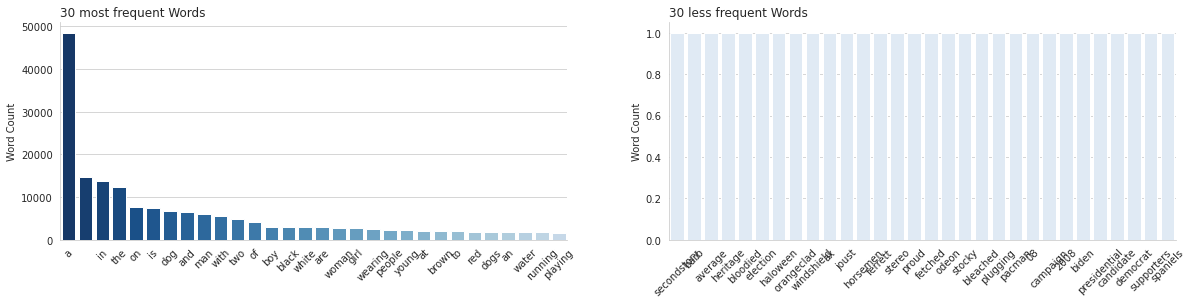

In [16]:
n = 30
word_counts = processor.count_words()
word_counts = pd.Series(word_counts).sort_values(ascending=False)
word_counts = word_counts.drop([processor.end_token, processor.start_token, processor.fill_token])
frequent_words = word_counts.head(n)

fig = plt.subplots(figsize=(20, 4))
plt.subplot(1,2,1)
p = sns.barplot(x=frequent_words.index, y=frequent_words, palette=sns.color_palette('Blues_r', n+10)[:n])
p.set_title(f'{n} most frequent Words', loc='left')
p.set_ylabel('Word Count')
plt.xticks(rotation=45)
sns.despine()

plt.subplot(1,2,2)
not_frequent_words = word_counts.tail(n)
p = sns.barplot(x=not_frequent_words.index, y=not_frequent_words, color=sns.color_palette('Blues_r', n)[-4])
p.set_title(f'{n} less frequent Words', loc='left')
p.set_ylabel('Word Count')
plt.xticks(rotation=45)
sns.despine()

plt.show()

**Beschreibung:**

Auc hier kann man die Rechtsshiefe Form der oberen Verteilung bereits erkennen. Dabei sieht man dass Füllwörter und Präppositionen an erster Stelle auftauchen, was auch so zu erwarten war. Sehr interessant sind Wörter die danach auftauche wie: man, Two, black, woman, girl etc. Dies gibt bereits einen kleinen Aufschluss darüber was auf den Bildern mehrheitlih zu sehen ist. Ein Entfernen der oft vorkommenden Wörter macht denke ich nicht viel sinn, da diese Wörter gebraucht werden, um anständige Sätze zu bilden. Bei den oftvorkommenden Wörtern kann man erkennen, dass zB sehr of die Wörter `dog, man, boy, woman etc` vorkommen. Dies könnte unter Umständen schlecht für das Modell sein, wenn die Bilder mehrheitlich aus  "Objekten" besteht.

Im rechten Plot sind die seltensten Wörter zu sehen, die sich natürlich im Plot stets unterscheiden, da alle meistens nur einmal auftauchen. Die Wörter sind wurden sehr selten zur Beschreibung der Bilder gebraucht. Daher ist daraus zu schliessen, dass diese Bilder nur einmal im Datensatz auftauchen. Es könnte durchaus sinn machen die wenigvorkommenden Wörter zu löschen, da vermutlich die Datengrundlage zu klein ist, um hier ein Modell anzulernen. Ich werde somit Wörter entfernen die nur einmal vorkommen.

In [17]:
word_counts[word_counts == 1].shape

(3084,)

Wir sehen, dass wir sehr viele Wörter haben, die nur einmal in den Daten vorkommen, deshalb möchte ich diese Wörter mit dem Tag UNK kennzeichnen, da die Datenmenge für jene zu klein ist um passend angelernt zu werden. Ein Vorteil hierbei ist auch die Reduktion der Datenmenge.

In [18]:
processor = TextHandler(n_processes=7, max_sequence_length=None, pad_fill=False, unknown_threshold=1)

In [19]:
processor.fit(image_captions['caption'].tolist())

In [20]:
save_as_pickle = True

if save_as_pickle:
    with open('./data/wtoi_reduced.pkl', 'wb') as pkl_file:
        pickle.dump(processor.text_dict, pkl_file)

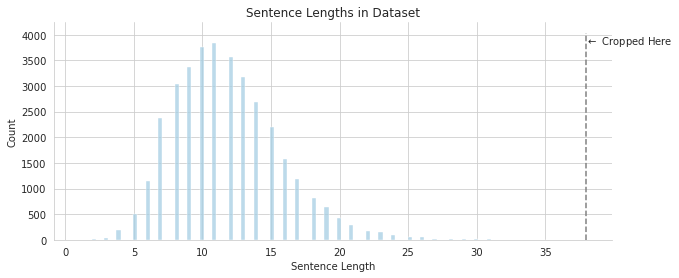

In [21]:
fig = plt.subplots(figsize=(10, 4))
p = sns.histplot(processor.sentence_lengths)
plt.vlines(x=processor.longest_word, ymin=p.axis()[-2], ymax=p.axis()[-1], 
           color='grey', linestyles='--')
plt.text(x=processor.longest_word, y=p.axis()[-1]*.90, s=r'$\leftarrow$ Cropped Here')
p.set_title('Sentence Lengths in Dataset')
p.set_xlabel('Sentence Length')
sns.despine()
plt.show()

**Beschreibung:**

Man kann sehen, dass die meisten Längen eher Normalverteilt sind mit Mittelwert um 10. Es hat einige Satzlängen, die sehr lange sind und als Ausreisser bezeichnet werden können.
Ich denke, dass es sinn macht diese Sätze zu reduzieren oder auch zu entfernen in unserem Datensatz. Vorerst werde ich diese Grösse jedoch beibehalten.

### Tokenizer Test

In [22]:
assert all([len(l) for l in processor.tokenized_text]) == True

In [23]:
image_captions['caption'].tolist()[:2]

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .']

In [24]:
transformed_sentences = processor.transform(image_captions['caption'].tolist())
transformed_sentences[:2]

[tensor([ 0,  4,  5,  6,  7,  4,  8,  6,  9, 10,  1]),
 tensor([ 0,  4,  5,  6,  7,  4, 11,  6, 12, 13, 14, 15, 16, 17, 18, 19,  1])]

In [25]:
transformed_sentences[3].shape

torch.Size([15])

In [26]:
assert all([len(l) for l in transformed_sentences]) == True

In [27]:
processor.inverse_transform(transformed_sentences)[:2]

['<START> a black dog and a spotted dog are fighting <END>',
 '<START> a black dog and a tricolored dog playing with each other on the road  <END>']

In [28]:
example = processor.transform(['My name is Simon and i like deep learning .'])
example

tensor([   0,    2, 4564,   46,    2,    7, 3197, 1024,  561, 3168,   19,    1])

In [29]:
processor.inverse_transform([example])

['<START> <UNK> name is <UNK> and i like deep learning  <END>']

Wie man an dieser Aussage sehen kann wurde das Neue Wort, dass noch nicht in den Daten drinnen war als `<UNK>` gekennzeichnet, was die Abk. unbekannt kennzeichnet.

## Loading Data

In [30]:
torch.cuda.is_available()

False

In [31]:
image_transforms = Compose([ToPILImage(),
                            Resize((224, 224)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])

image_transforms_unnormalized = Compose([ToPILImage(),
                                        Resize((224, 224)), 
                                        ToTensor()])

In [32]:
train_dataset = CustomDataset(annotations_file='./data/train_captions.csv', img_dir='./data/Images/', 
                              annot_transform=processor.transform, image_transform=image_transforms)
test_dataset = CustomDataset(annotations_file='./data/test_captions.csv', img_dir='./data/Images/', 
                              annot_transform=processor.transform, image_transform=image_transforms)

train_dataset_unnormalized = CustomDataset(annotations_file='./data/train_captions.csv', img_dir='./data/Images/', 
                              annot_transform=processor.transform, image_transform=image_transforms_unnormalized)
test_dataset_unnormalized = CustomDataset(annotations_file='./data/test_captions.csv', img_dir='./data/Images/', 
                              annot_transform=processor.transform, image_transform=image_transforms_unnormalized)

# Modellierung

Der Trainingsprozess wurde in separate Notebooks ausgelagert, aufgrund der GPU-Nutzung. Deshalb importiere ich hier nur die trainierten Modelle. Das Notebook kann auf Kaggle gefunden werden und zwar [-> hier](https://www.kaggle.com/simonstaehli/image-captioniong-flickr8k-pytorch)

In [33]:
from program.networks import EncoderCNN, DecoderRNN

In [34]:
# Set seed to receive equal results
torch.manual_seed(0)

# Load dataloader from custom dataset
dataloader_train = DataLoader(dataset=train_dataset, batch_size=16, 
                              num_workers=2, shuffle=True, 
                              collate_fn=collate_fn)
dataloader_test = DataLoader(dataset=test_dataset, batch_size=16, 
                             num_workers=2, shuffle=True, 
                             collate_fn=collate_fn)

dataloader_train_unnormalized = DataLoader(dataset=train_dataset_unnormalized, batch_size=16, 
                              num_workers=2, shuffle=True, 
                              collate_fn=collate_fn)
dataloader_test_unnormalized = DataLoader(dataset=test_dataset_unnormalized, batch_size=16, 
                             num_workers=2, shuffle=True, 
                             collate_fn=collate_fn)

In [35]:
# Load trained models
encoder_pretrained = torch.load('./models/pretrained/encoder30eps_482ed_384hs', map_location='cpu')
decoder_pretrained = torch.load('./models/pretrained/decoder30eps_482ed_384hs', map_location='cpu')
encoder_fulltrained = torch.load('./models/fulltrained/encoder20eps_482ed_384hs_2_untrained', map_location='cpu')
decoder_fulltrained = torch.load('./models/fulltrained/decoder20eps_482ed_384hs_2_untrained', map_location='cpu')

In [36]:
# Set models into evaluation mode
for network in [encoder_pretrained, decoder_pretrained, encoder_fulltrained, encoder_pretrained]:
    network.cpu()
    network.eval()

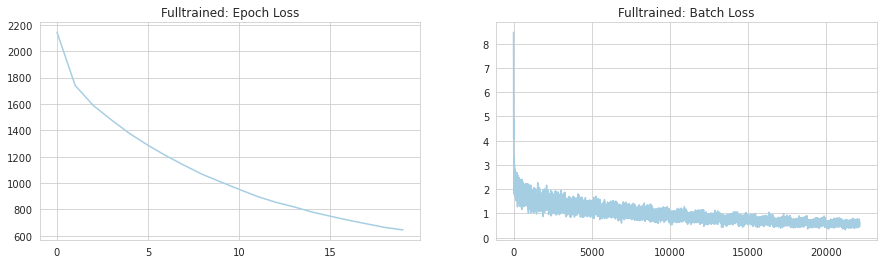

In [37]:
with open('./models/fulltrained/results20eps_untrained.pkl', 'rb') as pkl_file:
    results_fulltrained = pickle.load(pkl_file)

fig = plt.subplots(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(results_fulltrained['epoch'])
plt.title('Fulltrained: Epoch Loss')
plt.xticks(np.arange(0, 20, 5))

plt.subplot(1,2,2)
plt.plot(results_fulltrained['batch'])
plt.title('Fulltrained: Batch Loss')

plt.show()

Die beiden Plots zeigen die Entwicklung der Kosten über Epochen und Batches hinweg.  Der stärkste Abstieg der Kostenfunktion kann in den ersten Epochen beobachtete werden, danach eher abflachend, da auch mit einem Learning-Rate Scheduler gearbeitet wurde.

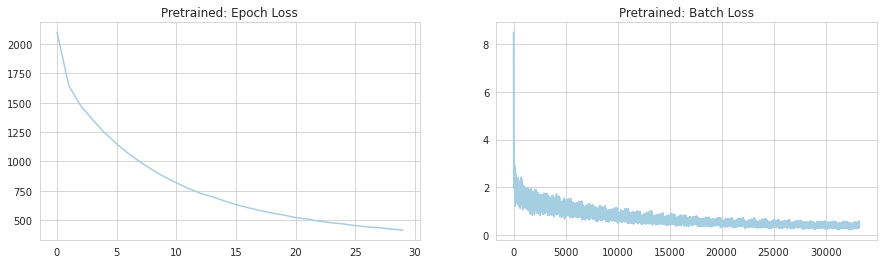

In [38]:
with open('./models/pretrained/results30_eps.pkl', 'rb') as pkl_file:
    results_pretrained = pickle.load(pkl_file)
    
fig = plt.subplots(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(results_pretrained['epoch'])
plt.title('Pretrained: Epoch Loss')

plt.subplot(1,2,2)
plt.plot(results_pretrained['batch'])
plt.title('Pretrained: Batch Loss')

plt.show()

Das Modell mit dem vortranierten CNN-Encoder wurde auf mehreren Epochen traininert. Die Kurven der Netzwerkarchitekturen sehen ähnlich aus. Auch das Niveau der Kostenfunktion nach 20 Epochen scheint ähnlich zu sein.

## Sampling Images

In [39]:
# Define Inverse Transforms for viewing the images
inverse_transform = Compose([ Normalize(mean = [ 0., 0., 0. ],
                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                             Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                       std = [ 1., 1., 1. ]), 
                             ToPILImage()])

In [40]:
def generate_captions(encoder, decoder, test_batch, inverse_transform, limit: int = None, add_actual: bool = True, 
                      end_token_id: int = 1, start_token_id: int = 0, pad_token_id: int = 3, **kwargs):    
    """
    Takes an Image Batch and returns Images with a predicted and True Caption.
    
    params:
    -------------
    encoder: 
        Encoder Network 
    decoder: 
        Decoder Network
    
    test_batch: 
        Test Batch from Dataloder 
        generated by test_batch=next(iter(dataloader))
    
    add_actual = True
        Wether to add actual caption or not
    
    limit: 
        Plot Limit of images. Needs to be chosen smaller than batch size
        
    end_token_id: int = 1
        ID of end token from vocab
        
    start_token_id: int = 0
        ID of start token from vocab
        
    pad_token_id: int = 3
        ID of pad token from vocab   
        
    returns:
    ------------
    matplotlib figures
    
    """
    position_tokens = [start_token_id, end_token_id, pad_token_id]
    max_sequence_length = kwargs.get('max_sequence_length') if kwargs.get('max_sequence_length') else 30
    
    
    images, captions, _ = test_batch
    
    if limit:
        assert images.shape[0] >= limit
    
    ncols = 2
    nrows = (images.shape[0] // ncols ) + 1
    fig = plt.subplots(figsize=(20, nrows*4))
    
    with torch.no_grad():
        for i in range(images.shape[0] if not limit else limit):
            features = encoder(images[i].unsqueeze(0))
            predictions = decoder.predict(features.squeeze(), max_sequence_length, end_token_id)
                
            predictions = [tok for tok in predictions if tok not in position_tokens]
            predictions = processor.idx_to_word(np.array(predictions))
            if add_actual:
                actual = [tok for tok in captions[i] if tok not in position_tokens]
                actual = processor.idx_to_word(np.array(actual))            
            
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(inverse_transform(images[i]))
            plt.grid(False)
            plt.axis('off')
            if add_actual:
                plt.title('Predicted: ' + predictions + 
                          '\nActual: ' + actual, fontdict=dict(fontsize=10))
            else:
                plt.title('Predicted: ' + predictions)
            
        plt.subplots_adjust(hspace=.5)

        plt.show()

In [41]:
test_batch = next(iter(dataloader_test))

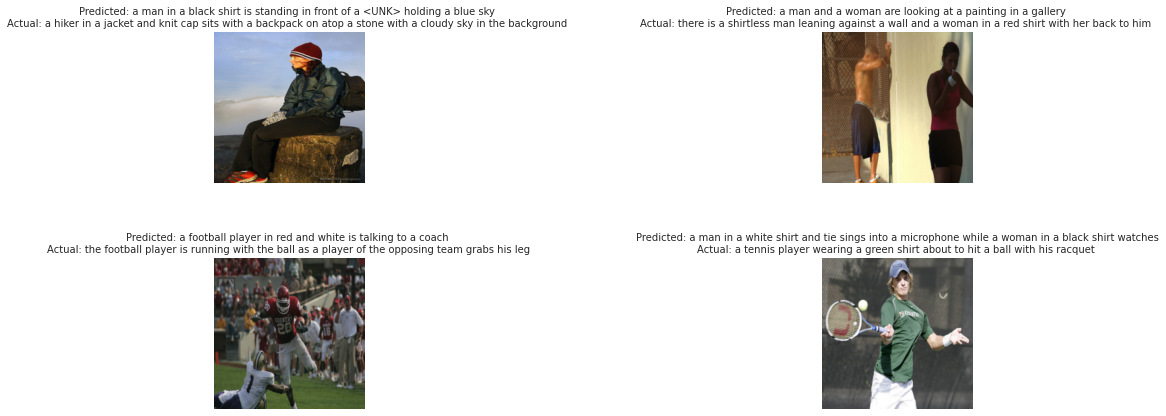

In [42]:
# Captions for Full-Trained Network
generate_captions(encoder=encoder_fulltrained, decoder=decoder_fulltrained, 
                  inverse_transform=inverse_transform, test_batch=test_batch, max_sequence_length=30, limit=4, 
                  end_token_id=processor.word_to_idx('<END>'), start_token_id=processor.word_to_idx('<START>'), 
                  pad_token_id=processor.word_to_idx('<PAD>'))

**Beschreibung:**

Das Netzwerk, welches nicht mit einem vorgelernten CNN-Netwerk trainiert wurde, retourniert Vorhersagen, die oftmals keinen Sinn ergeben. Das Netzwerk kann nicht erkennen, was genau auf dem Bild zu erkennen ist. In den Beispielen werden vor allem Hunde gut erkannt, was daran liegen könnte, dass der Datensatz über sehr viele Hundebilder verfügt. Vor allem Attribute, die Kleidung oder Farben beschreiben werden sehr schlecht erkannt und beschrieben.

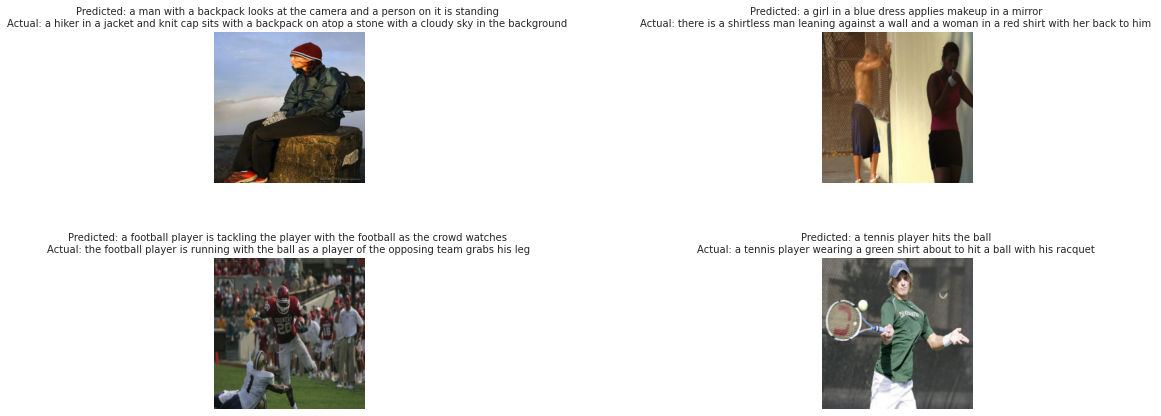

In [43]:
# Captions for Pre-trained CNN Network
generate_captions(encoder=encoder_pretrained, decoder=decoder_pretrained,
                  inverse_transform=inverse_transform,
                  test_batch=test_batch, max_sequence_length=30, limit=4, 
                  end_token_id=processor.word_to_idx('<END>'), start_token_id=processor.word_to_idx('<START>'), 
                  pad_token_id=processor.word_to_idx('<PAD>'))

**Beschreibung:**

Das mit Transfer-Learning trainierte Netzwerk erkennt viel besser, was auf einem Bild zu sehen ist, sprich die Objekte auf einem Bild. Das Netzwerk verwechselt hier und da den Kontext des Bildes, doch liefert weitaus bessere Ergebnisse als die Architektur mit dem trainierten CNN-Encoder.

# BLEU-Evaluation

In [44]:
def evaluate_bleu(encoder: EncoderCNN, decoder: DecoderRNN, test_size: int = 20, bleu_max_ngram: int = 3,
                  test_images_dir: str ='./data/test/', test_captions_path: str = './data/test_captions.csv', 
                  position_tokens: list = [0, 1, 3], **kwargs):
    """
    Takes Encoder and Decoder as input and returns Bleu-Score on images from given set of captions. 
    Will always take all captions in the testset as reference corpus and the predicted caption as reference corpus.
    
    params:
    ----------
    encoder
        Encoder Network
        
    decoder
        Decoder Network
        
    test_size: int
        Size of the batch which should be tested on. Needs to be smaller than total amount 
        of images in test batch.
    
    bleu_max_ngram: int
        Sets the N-gram parameter for the calculation of bleu-scores. Weights will be automatically set
        to 1/bleu_max_ngram for each N-gram.
    
    test_images_dir='./data/test/'
        Path to image dir with all relevant images.
        
    test_captions_path = './data/test_captions.csv'
        path to captions file with all test_captions nevers seen by the network.
    
    position_tokens=[0, 1, 3] :
        Postional Tokens used in tokenization of captions
    
    **kwargs:
        'random_state' for equal sampling
    
    returns:
    ------------
    bleu_scores: list
        list of all calculated bleu_scores
    
    """
    test_images = os.listdir(test_images_dir)
    test_captions = pd.read_csv(test_captions_path)
    np.random.seed(seed=kwargs.get('random_state'))
    position_tokens = [0, 1, 3]
    
    if test_size:
        sample_image_names = test_captions['image'].unique()
        np.random.shuffle(sample_image_names)
        sample_image_names = sample_image_names[:test_size]
    else:
        sample_image_names = test_captions['image'].unique()
    sample_captions = test_captions[test_captions['image'].isin(sample_image_names)]
    
    scores = []
    with torch.no_grad():
        for img_name in tqdm(sample_image_names, desc='Calculating BLEU-Scores for {}-grams'.format(bleu_max_ngram)):
            
            img_path = os.path.join(test_images_dir, img_name)
            image = read_image(img_path)

            all_captions = sample_captions.loc[sample_captions['image'] == img_name, 'caption'].to_list()
            all_captions = processor.transform(all_captions)
            all_captions = [caption[1:-1] for caption in all_captions]
            all_captions = processor.inverse_transform(all_captions)
            all_captions = [caption.strip().split(' ') for caption in all_captions]
            max_sequence_length = max([len(cap) for cap in all_captions])

            image = image_transforms(image).unsqueeze(0)
            features = encoder(image)
            prediction = decoder.predict(features=features.squeeze(), max_sentence_length=max_sequence_length, end_token_id=1)
            prediction = [tok for tok in prediction if tok not in position_tokens]
            prediction = processor.idx_to_word(np.array(prediction))
            prediction = prediction.strip().split(' ')
            
            bleu_weights = [1/bleu_max_ngram for i in range(bleu_max_ngram)]
            score = bleu_score(candidate_corpus=[prediction], references_corpus=[all_captions], 
                               max_n=bleu_max_ngram, weights=bleu_weights)
            scores.append(score)
    
    return scores

In [45]:
fulltrained_results = []
for n_gram in range(1, 4):
    scores_fulltrained = evaluate_bleu(encoder=encoder_fulltrained, decoder=decoder_fulltrained, 
                                       test_size=100, bleu_max_ngram=n_gram,
                                       test_images_dir='./data/Images', 
                                       test_captions_path = './data/test_captions.csv', 
                                       position_tokens=[0, 1, 3], random_state=11)
    fulltrained_results.append(scores_fulltrained)

Calculating BLEU-Scores for 1-grams:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating BLEU-Scores for 2-grams:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating BLEU-Scores for 3-grams:   0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
pretrained_results = []

for n_gram in range(1,4):
    scores_pretrained = evaluate_bleu(encoder=encoder_pretrained, decoder=decoder_pretrained, 
                                      test_size=100, bleu_max_ngram=n_gram,
                                      test_images_dir='./data/Images', 
                                      test_captions_path = './data/test_captions.csv', 
                                      position_tokens=[0, 1, 3], 
                                      random_state=11)
    pretrained_results.append(scores_pretrained)

Calculating BLEU-Scores for 1-grams:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating BLEU-Scores for 2-grams:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating BLEU-Scores for 3-grams:   0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
fulltrained_mean_results = [np.mean(res) for res in fulltrained_results]
pretrained_mean_results = [np.mean(res) for res in pretrained_results]
print('Results Full-Trained Network BLEU-N:', dict(enumerate(fulltrained_mean_results, 1)))
print('Results Pre-trained Network BLEU-N:', dict(enumerate(pretrained_mean_results, 1)))

Results Full-Trained Network BLEU-N: {1: 0.4369740393954845, 2: 0.21474916245644798, 3: 0.07965768657032588}
Results Pre-trained Network BLEU-N: {1: 0.5049744710539498, 2: 0.3009520965175789, 3: 0.1369825564141652}


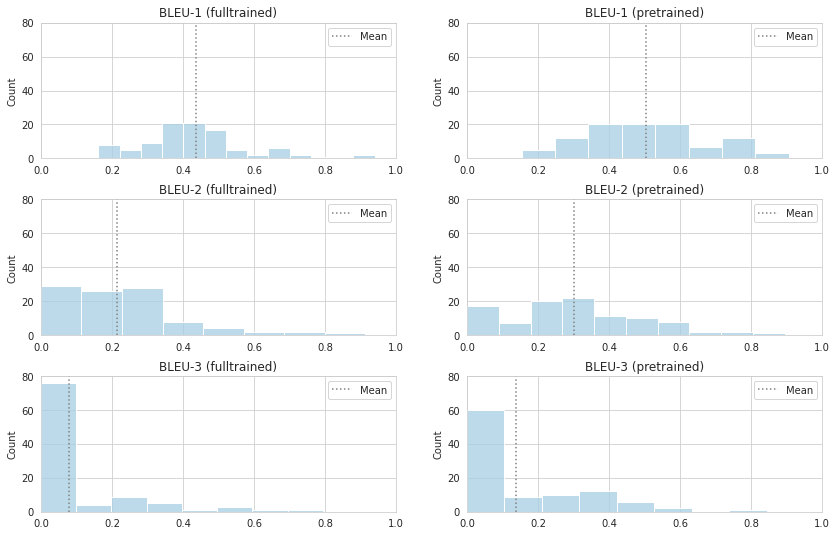

In [48]:
nrows = len(fulltrained_results)

fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(14, nrows*3))

for i in range(len(fulltrained_results)):
    p = sns.histplot(x=fulltrained_results[i], ax=ax[i, 0])
    p.set_title(f'BLEU-{i+1} (fulltrained)')
    p.vlines(x=np.mean(fulltrained_results[i]), ymin=0, ymax=80, color='grey', linestyles='dotted')
    p.legend(['Mean'])
    p.set_ylim(0, 80)
    p.set_xlim(0,1)
    
    p = sns.histplot(x=pretrained_results[i], ax=ax[i, 1])
    p.set_title(f'BLEU-{i+1} (pretrained)')
    p.vlines(x=np.mean(pretrained_results[i]), ymin=0, ymax=80, color='grey', linestyles='dotted', label='Mean')
    p.legend(['Mean'])
    p.set_ylim(0, 80)
    p.set_xlim(0,1)
    
plt.subplots_adjust(hspace=.3)
plt.show()

**Beschreibung:**

Wenn beide Durchschnittlichen Resultate verglichen werden, dann erzielt das vortrainierte Netzwerk bessere Resultate im Sinne des BLEU über alle N-Gramme hinweg. Auch in Anbetracht der Verteilungen sind durchaus mehrere Werte grösser als 0 und zeigen somit etwas mehr Übereinstimmung der generierten Token mit den wirklichen Token. 

Es erzielen jedoch beide Netzwerke viele schlechte Resultate desto grösser man die N-Gramme wählt zur Berechnung des BLEU-Scores, sprich schlechte Captions im Vergleich mit den Soll-Captions, was anhand der vielen Nullwerte zu sehen ist. Dieses Resultat ist jedoch plausibel, da längere Kontext für ein Modell generell schwieriger zu treffen ist.

# Anwendung auf Eigene Bilder

In [49]:
# Read and join paths to load images
custom_images_path = './data/custom_images/'
custom_images = os.listdir(custom_images_path)
custom_images = [''.join([custom_images_path, img]) for img in custom_images]

In [50]:
# Prepare Tuple for generation of Captions wwith (images, captions, lengths)
custom_images_stack = torch.Tensor([])
for i , image in enumerate(custom_images):
    image = image_transforms(read_image(image))
    if i == 0:
        custom_images_stack = image.unsqueeze(0)
    else:
        custom_images_stack = torch.cat([custom_images_stack, image.unsqueeze(0)], 0)
custom_images_batch = (custom_images_stack, '_', '_')

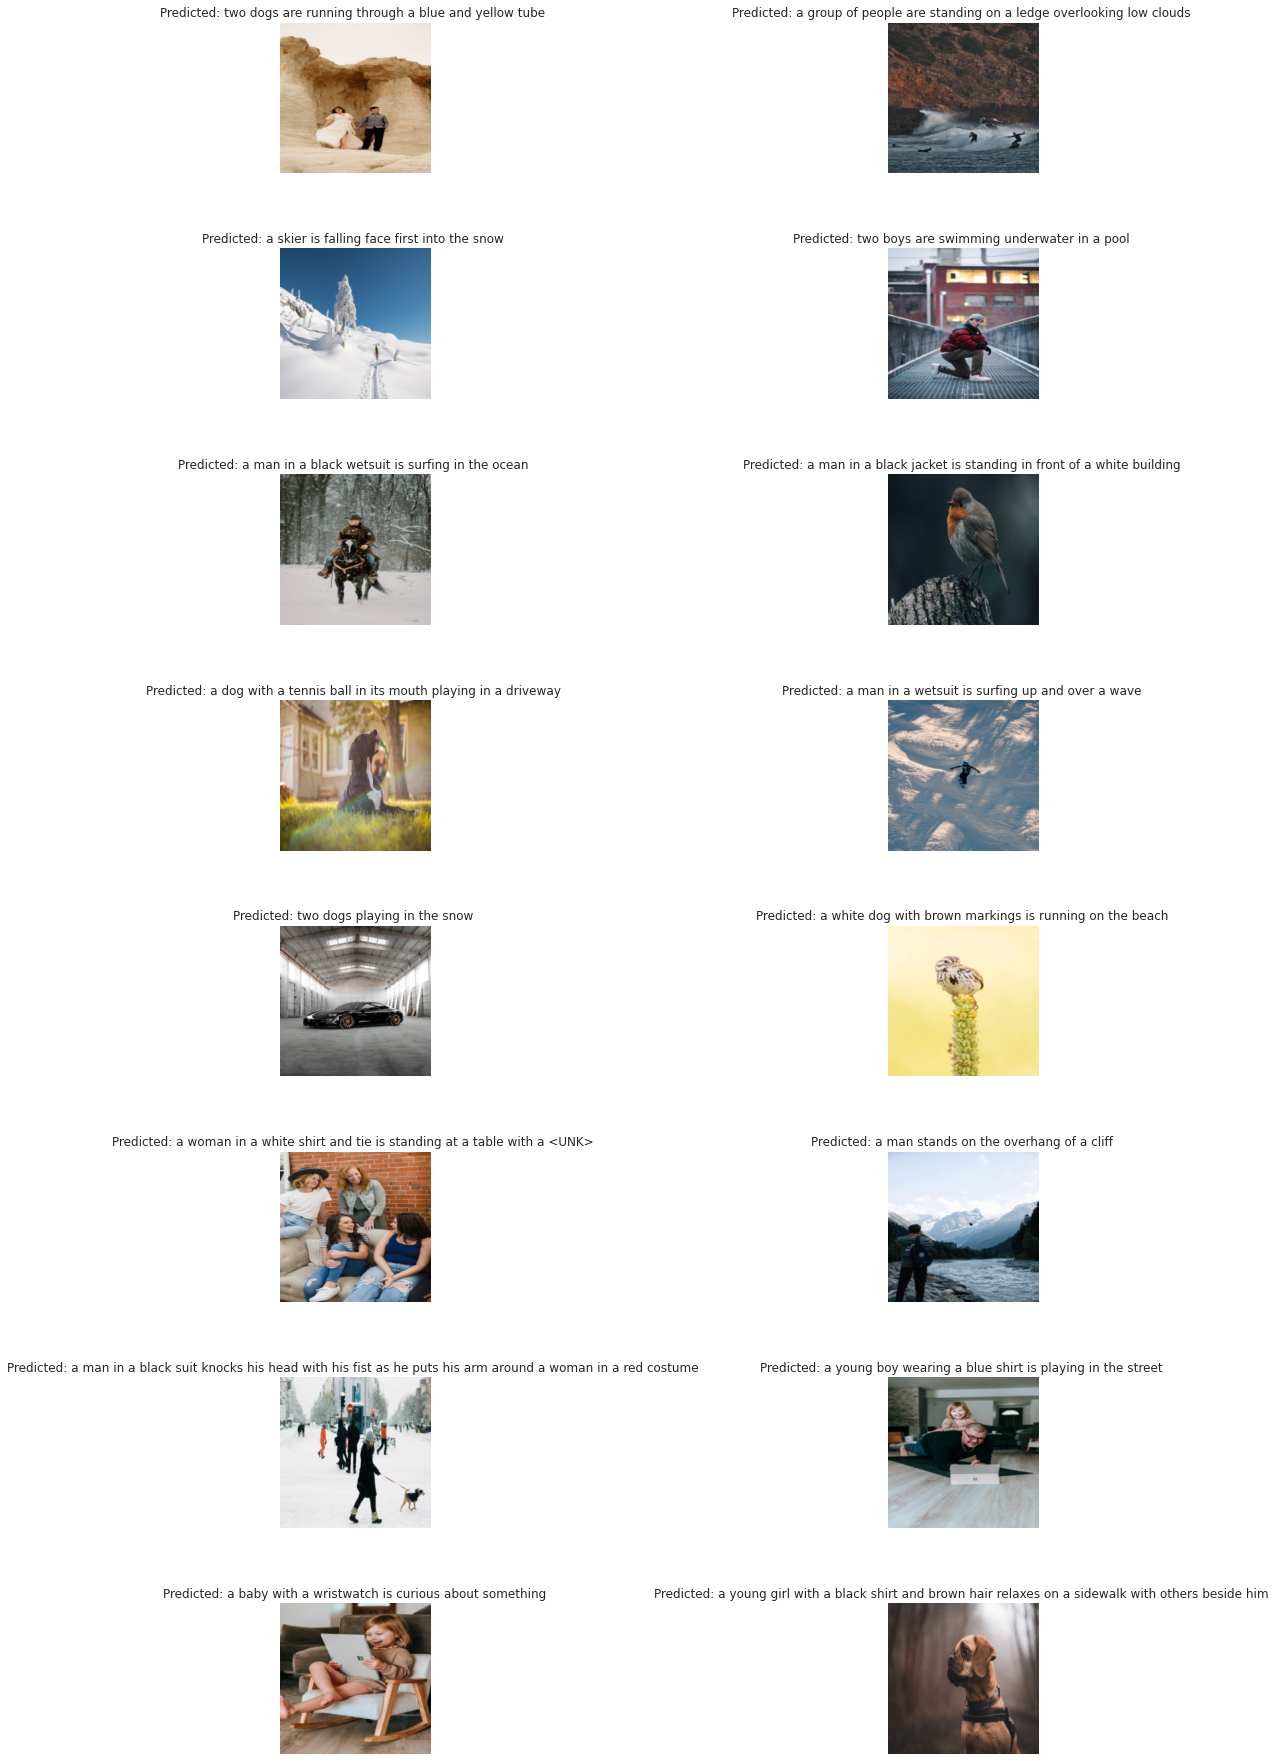

In [51]:
# Captions for Full-Trained Network
generate_captions(encoder=encoder_fulltrained, decoder=decoder_fulltrained, add_actual=False,
                  test_batch=custom_images_batch, max_sequence_length=30, inverse_transform=inverse_transform, 
                  end_token_id=processor.word_to_idx('<END>'), start_token_id=processor.word_to_idx('<START>'), 
                  pad_token_id=processor.word_to_idx('<PAD>'))

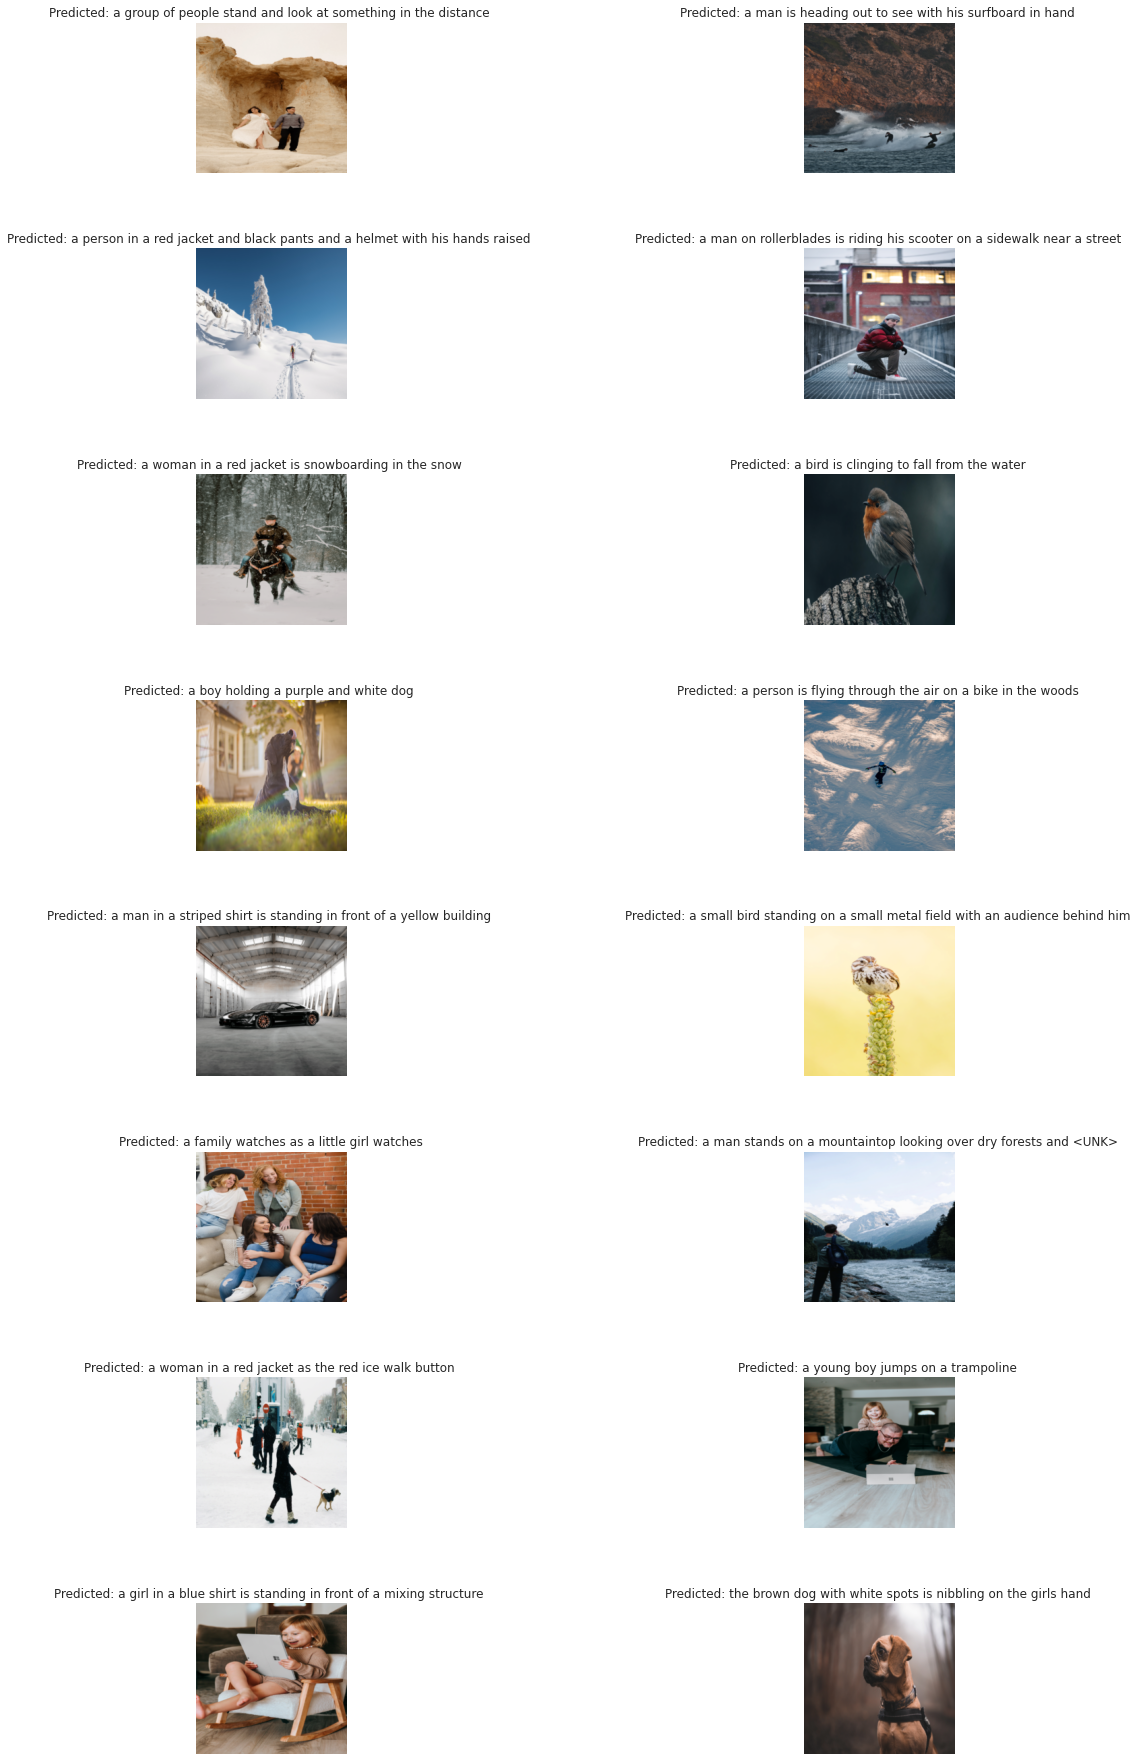

In [52]:
# Captions for pretrained Network
generate_captions(encoder=encoder_pretrained, decoder=decoder_pretrained, add_actual=False,
                  test_batch=custom_images_batch, max_sequence_length=30, inverse_transform=inverse_transform,
                  end_token_id=processor.word_to_idx('<END>'), start_token_id=processor.word_to_idx('<START>'), 
                  pad_token_id=processor.word_to_idx('<PAD>'))

**Beschreibung:**

Die Bilder wurden von der Webseite [Unsplash.com](htps://unsplash.com/) heruntergeladen, danach mit dem gleichen Pre-processing überarbeitet, mit welchem das Modell trainiert wurde.

Man sieht auch hier wieder den Unterschied zwsichen beiden Modellen. Das Untere Modell erkennt Objekte besser, wobei bei beiden Modellen meistens die Farbgebung sehr schlecht erkannt werden. Ein Grund dafür könnte das Pre-Processing der Bilder sein.

Die Captions wurden auf einem spezifischen Datensatz trainiert und man sieht, dass das Modell nicht auf irgendwelche Daten anwendbar ist, die nicht aus dem urpsrüunglichen Datensatz entspringen. Ich nehme an, als man die Samples aus dem Flickr8k Datensatz gezogen hat, hat man spezifiche Bildklassen in den Fokus gesetzt. Grundsätzlich erkennt vor allem das untere Modell meistens das grundlegende Objekt im Bild, doch der Kontext des Bildes wird dann nicht richtig beschrieben. Meine Auswahl der Bilder könnte deshalb ein wenig Off-Topic erscheinen und dennoch interessant, welche Caption das Modell für diese Bilder ausgibt.

# Fazit

Ich denke, in dem ich den Bleu-Score oder eine passende Evaluation noch in den Trainingsprozess miteingebunden hätte, dann hätte ich das Modell besser trainineren und dementsprechend auf bisher ungesehene Daten generalisieren können. Es kann gut sein, dass das Modell bereits zu stark auf den Datensatz gefittet wurde und daher auch oftmals Hunde erkannt werden, obwohl gar keine Hunde im Bild zu sehen sind. Die Netzwerke, die ich hier trainiert habe, erreichen bei weitem nicht die Performances wie sie bspw. [Patel et al. (p.5, 2019)](https://arxiv.org/pdf/2006.10923.pdf) erreicht haben siehe BLEU-3: 29.08 mit ähnlicher Architektur. Natürlich hätte man hier auch noch einige Hyperparameter verändern können und schauen, wie es sich auf das Resultat auswirkt. Auch ich habe noch die Annahme getätigt, dass durch das Pre-processing der Bilder die eigentliche Farbgebung verzerrt wird, was es womöglich schwiergier machen könnte für ein Modell die Farben zu erkennen. Oftmals ordnet das Modell die falschen Farben zu.

# Sources

Automatic Image Captioning Using Deep Learning. (2018, April 2). Analytics Vidhya. https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/

Image Captioning Example Doubt in input size of Decoder LSTM - vision. (2018, März 3). PyTorch Forums. https://discuss.pytorch.org/t/image-captioning-example-doubt-in-input-size-of-decoder-lstm/14296

Ulyanin, S. (2019, Februar 23). Captioning Images with PyTorch. Medium. https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3
Vinyals, O., Toshev, A., Bengio, S., & Erhan, D. (2015). Show and Tell: A Neural Image Caption Generator. arXiv:1411.4555 [cs]. http://arxiv.org/abs/1411.4555

Word Embeddings: Encoding Lexical Semantics—PyTorch Tutorials 1.10.1+cu102 documentation. (o. J.). Abgerufen 17. Januar 2022, von https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

Patel, A., & Varier, A. (2020). Hyperparameter Analysis for Image Captioning. arXiv:2006.10923 [cs]. http://arxiv.org/abs/2006.10923
